# Assignment 1


In [119]:
# importing all package here
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numbers
from functools import partial
from google import genai
import os

Utilities functions and Abstract Class

In [120]:
def generate_random_array_with_max_sum(n, max_sum):
    random_values = np.random.rand(n)

    scaled_values = (random_values / random_values.sum()) * (max_sum - np.random.randint(max_sum))

    result = scaled_values

    return result

In [121]:
class CongestionAlgorithm(ABC):
  def __init__(self, number_of_participants, band_width):
    self.number_of_participants = number_of_participants
    self.k_lastest_allocation = []
    self.band_width = band_width
  def redistribute_allocation(self, current_allocation):
    self.k_lastest_allocation.append(current_allocation)
    self.current_allocation = current_allocation
    self._redistribute_allocation(current_allocation)
    return current_allocation
  @abstractmethod
  def _redistribute_allocation(self, current_allocation):
    raise NotImplementedError
  def get_total_allocation(self, current_allocation):
    return np.sum(current_allocation)

In [122]:
class TCPNetwork:
  def __init__(self, number_of_participants, band_width, algorithm_class: CongestionAlgorithm, iteration=100, **kwargs):
    self.max_iteration = iteration
    self.number_of_participants = number_of_participants
    self.allocation = generate_random_array_with_max_sum(number_of_participants, band_width)
    self.band_width = band_width
    print(self.allocation)
    self.congestion_algorithm = algorithm_class(number_of_participants, band_width)
  def monitor_network(self, verbose=False):
    current_iteration = 0
    first_user_allocation = []
    second_user_allocation = []
    while(current_iteration < self.max_iteration):
      if verbose:
        print(self.allocation)
      first_user_allocation.append(self.allocation[0])
      second_user_allocation.append(self.allocation[1])
      current_iteration += 1
      self.allocation = self.congestion_algorithm.redistribute_allocation(self.allocation)


    ## plot
    fig = plt.figure(figsize=(16, 16), layout="constrained")

    # Placing the plots in the plane
    ax = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=6)
    plot2 = plt.subplot2grid((10, 2), (6, 0), colspan=2, rowspan=2)
    plot3 = plt.subplot2grid((10, 2), (8, 0), colspan=2, rowspan=2)

    # Scatter plot of first_user_allocation (X) vs. second_user_allocation (Y)
    ax.scatter(first_user_allocation, second_user_allocation, color='b', label='User Allocations')

    # Line plot for trend visualization (optional)
    ax.plot(first_user_allocation, second_user_allocation, 'r--', alpha=0.7)

    ax.set_xlim(0, max(first_user_allocation) + 2)  # Adding padding
    ax.set_ylim(0, max(second_user_allocation) + 2)
    x0, y0 = first_user_allocation[0], second_user_allocation[0]
    ax.annotate("x0", (x0, y0), textcoords="offset points", xytext=(-10,10), ha='left', fontsize=12, color='red')

    # Labels and title
    ax.set_xlabel('First User Allocation')
    ax.set_ylabel('Second User Allocation')
    ax.set_title('First User Allocation vs. Second User Allocation')
    ax.set_aspect('equal')

    efficiency_line_x_values = np.linspace(0, self.band_width, self.band_width)
    efficiency_line_y_values = self.band_width- efficiency_line_x_values
    ax.plot(efficiency_line_x_values, efficiency_line_y_values, label='Efficiency Line', linestyle='dashed', linewidth=1)

    fairness_line_x_values = np.linspace(0, self.band_width*1.1, self.band_width)
    ax.plot(fairness_line_x_values, fairness_line_x_values, label='One-One fairness Line', linestyle='dashed', linewidth=1)

    # Show the legend
    ax.legend()

    rtt_values = np.linspace(0, self.max_iteration, self.max_iteration)
    plot2.plot(rtt_values, first_user_allocation, marker=".", color='black', linewidth=1)
    plot2.set_xlabel('Number of Transmissions (RTTs)')
    plot2.set_ylabel('First User Allocation')
    plot2.set_title('Congestion Window for $x_{1}$')
    plot2.set_xlim(0, len(first_user_allocation))
    plot2.grid(False)

    # Congestion Window plot for x2
    plot3.plot(rtt_values, second_user_allocation, marker=".", color='black', linewidth=1)
    plot3.set_xlabel('Number of Transmissions (RTTs)')
    plot3.set_ylabel('Second User Allocation')
    plot3.set_title('Congestion Window for $x_{2}$')
    plot3.set_xlim(0, len(second_user_allocation))
    plot3.grid(False)

    # Show the plot
    plt.savefig('network.png')
    plt.show()


## Tune Additive Increase and Multiplicative Decrease (AIMD)

In [123]:
class AIMDAlgorithm(CongestionAlgorithm):
  def __init__(self, number_of_participants, band_width, alpha_factor, beta_factor):
    self.alpha_factor = [alpha_factor] * number_of_participants if isinstance(alpha_factor, numbers.Number)  else alpha_factor
    self.beta_factor = [beta_factor] * number_of_participants if isinstance(beta_factor, numbers.Number) else beta_factor
    super().__init__(number_of_participants, band_width)
  def _redistribute_allocation(self, current_allocation):
    if self.get_total_allocation(current_allocation) <= self.band_width:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] + self.alpha_factor[i]
    else:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] * self.beta_factor[i]
    return current_allocation

In [124]:
Algorithm = partial(AIMDAlgorithm, alpha_factor=2, beta_factor=0.5)
tcp_network = TCPNetwork(2, 50, Algorithm, 100)

[5.62778964 7.37221036]


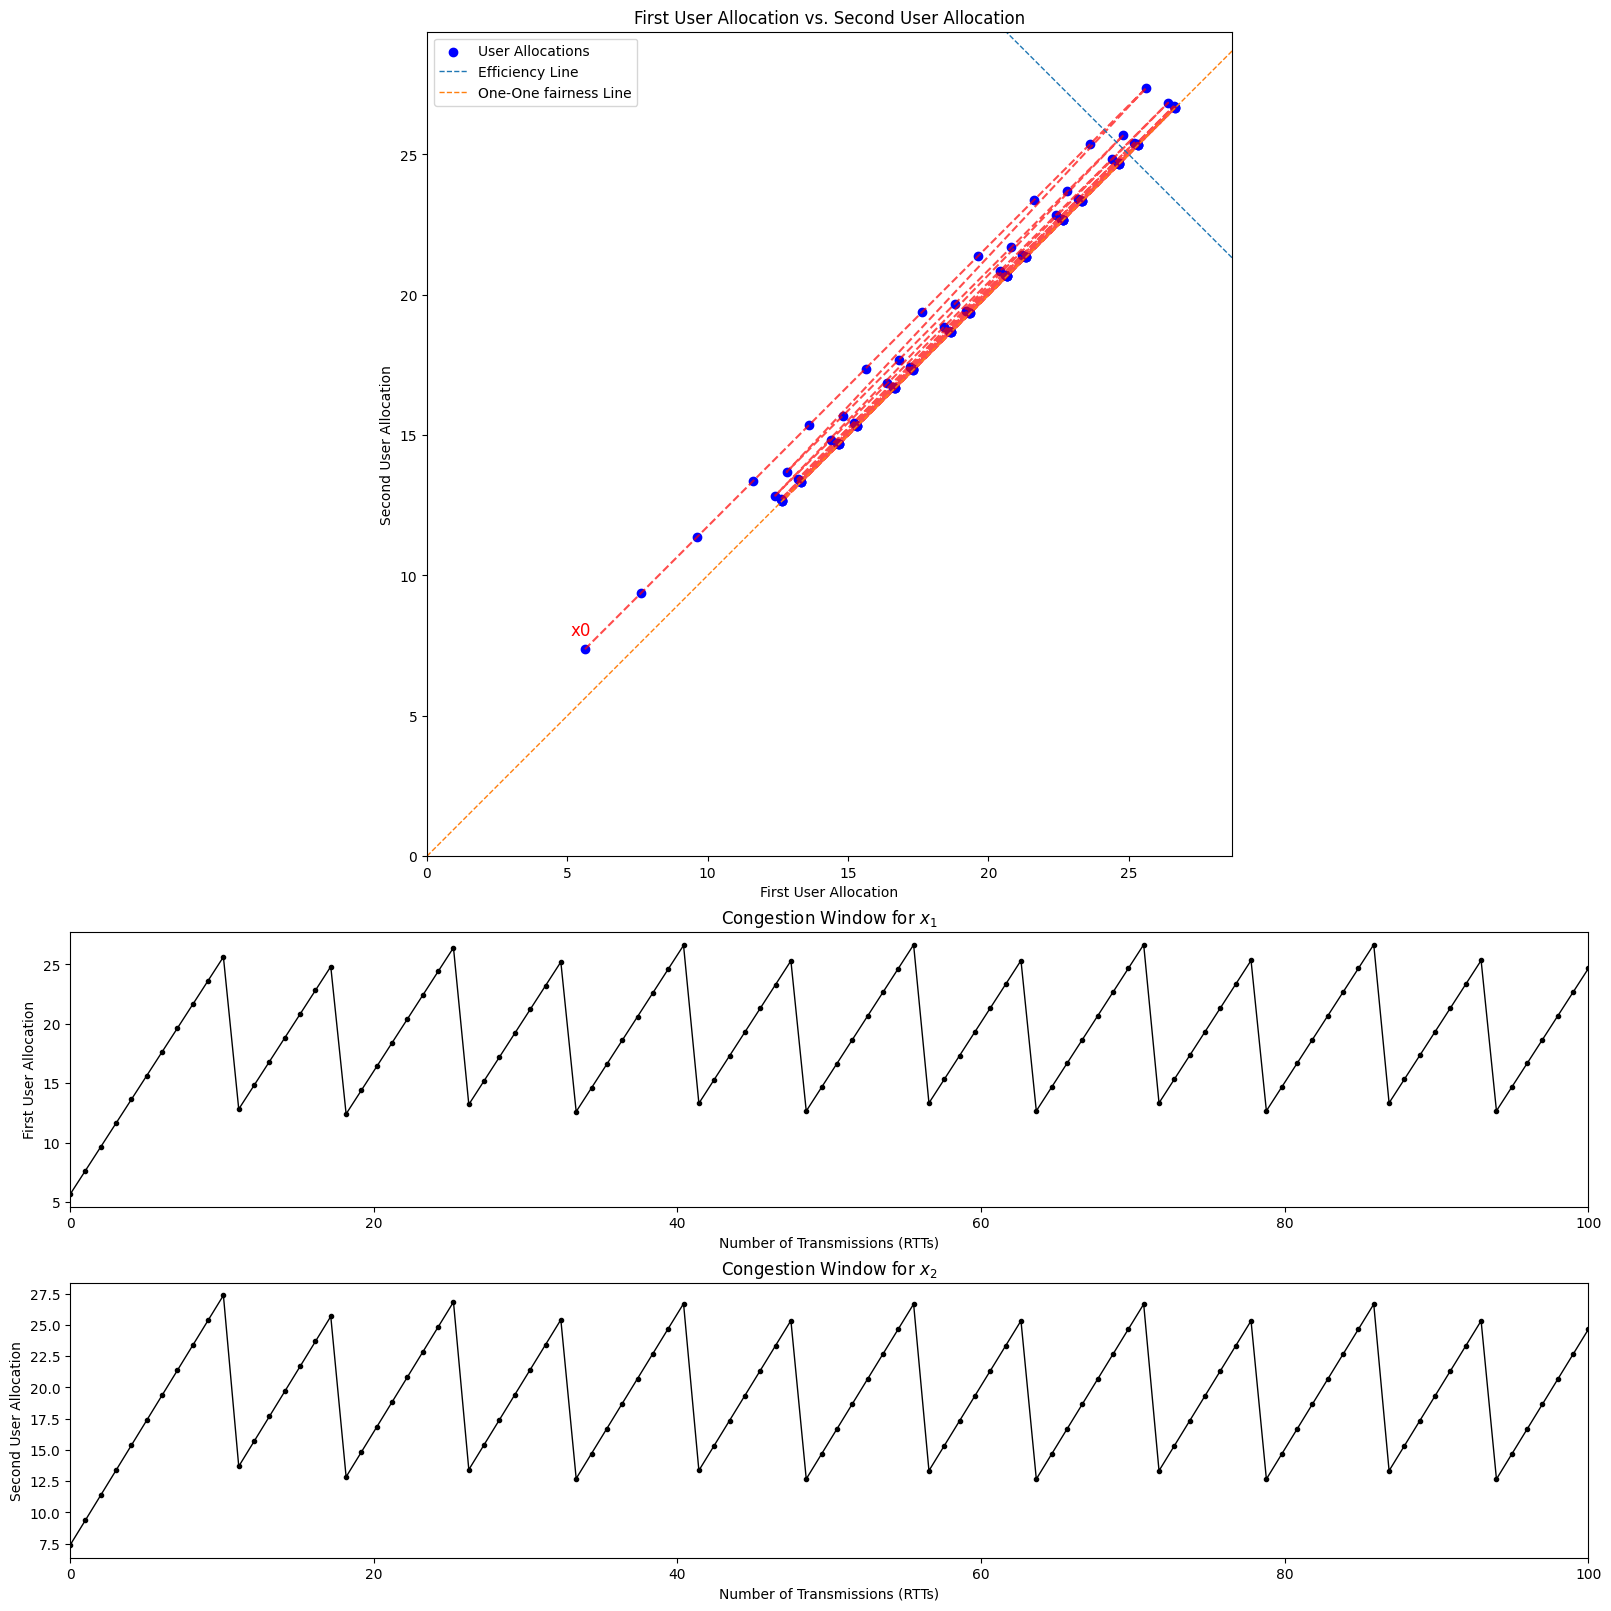

In [125]:
tcp_network.monitor_network()

### AIMD TCP network with N user

In [126]:
N = 5
Algorithm = partial(AIMDAlgorithm, alpha_factor=[1, 2, 3, 4, 5], beta_factor=[0.5, 0.6, 0.7, 0.3, 0.1])
tcp_network = TCPNetwork(N, 50, Algorithm, 1000)

[ 4.9158949  12.10402169  3.71903817  5.59963957  5.66140567]


[ 4.9158949  12.10402169  3.71903817  5.59963957  5.66140567]
[ 5.9158949  14.10402169  6.71903817  9.59963957 10.66140567]
[ 6.9158949  16.10402169  9.71903817 13.59963957 15.66140567]
[3.45794745 9.66241301 6.80332672 4.07989187 1.56614057]
[ 4.45794745 11.66241301  9.80332672  8.07989187  6.56614057]
[ 5.45794745 13.66241301 12.80332672 12.07989187 11.56614057]
[2.72897372 8.19744781 8.9623287  3.62396756 1.15661406]
[ 3.72897372 10.19744781 11.9623287   7.62396756  6.15661406]
[ 4.72897372 12.19744781 14.9623287  11.62396756 11.15661406]
[ 2.36448686  7.31846869 10.47363009  3.48719027  1.11566141]
[ 3.36448686  9.31846869 13.47363009  7.48719027  6.11566141]
[ 4.36448686 11.31846869 16.47363009 11.48719027 11.11566141]
[ 2.18224343  6.79108121 11.53154107  3.44615708  1.11156614]
[ 3.18224343  8.79108121 14.53154107  7.44615708  6.11156614]
[ 4.18224343 10.79108121 17.53154107 11.44615708 11.11156614]
[ 2.09112172  6.47464873 12.27207875  3.43384712  1.11115661]
[ 3.09112172  8.47

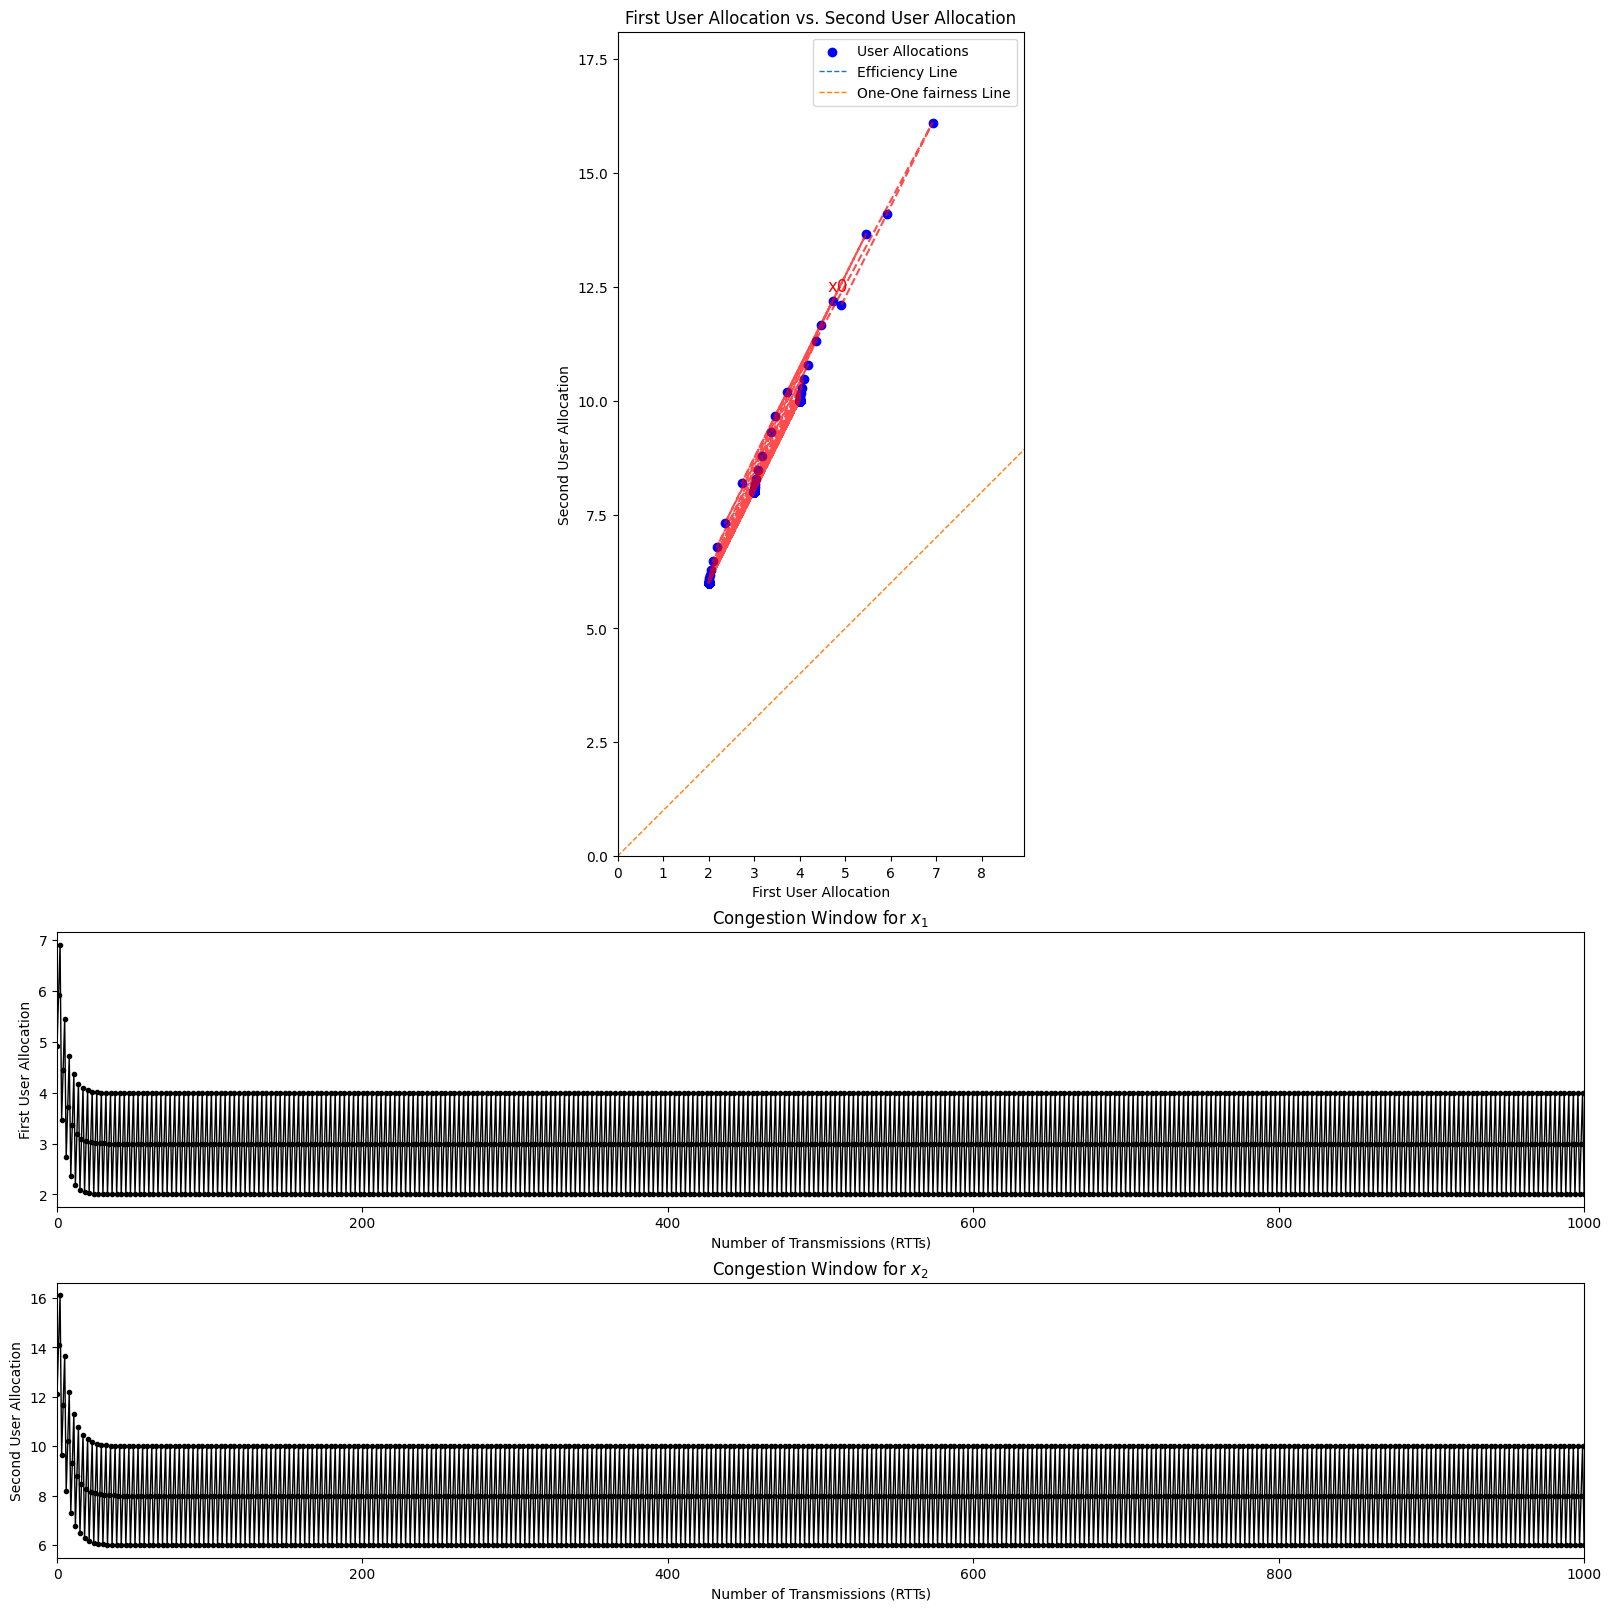

In [127]:
tcp_network.monitor_network(verbose=True)

## Power Increase and Multiplicative Decrease (MIMD) for TCP

In [128]:
class PIMDAlgorithm(CongestionAlgorithm):
  def __init__(self, number_of_participants, band_width, alpha_factor, beta_factor):
    self.alpha_factor = [alpha_factor] * number_of_participants if isinstance(alpha_factor, numbers.Number)  else alpha_factor
    self.beta_factor = [beta_factor] * number_of_participants if isinstance(beta_factor, numbers.Number) else beta_factor
    super().__init__(number_of_participants, band_width)
  def _redistribute_allocation(self, current_allocation):
    if self.get_total_allocation(current_allocation) <= self.band_width:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] + current_allocation[i] ** self.alpha_factor[i]
    else:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] * self.beta_factor[i]
    return current_allocation

In [129]:
Algorithm = partial(PIMDAlgorithm, alpha_factor=0.9, beta_factor=0.5)
tcp_network = TCPNetwork(2, 50, Algorithm, 100)

[22.11543589 24.88456411]


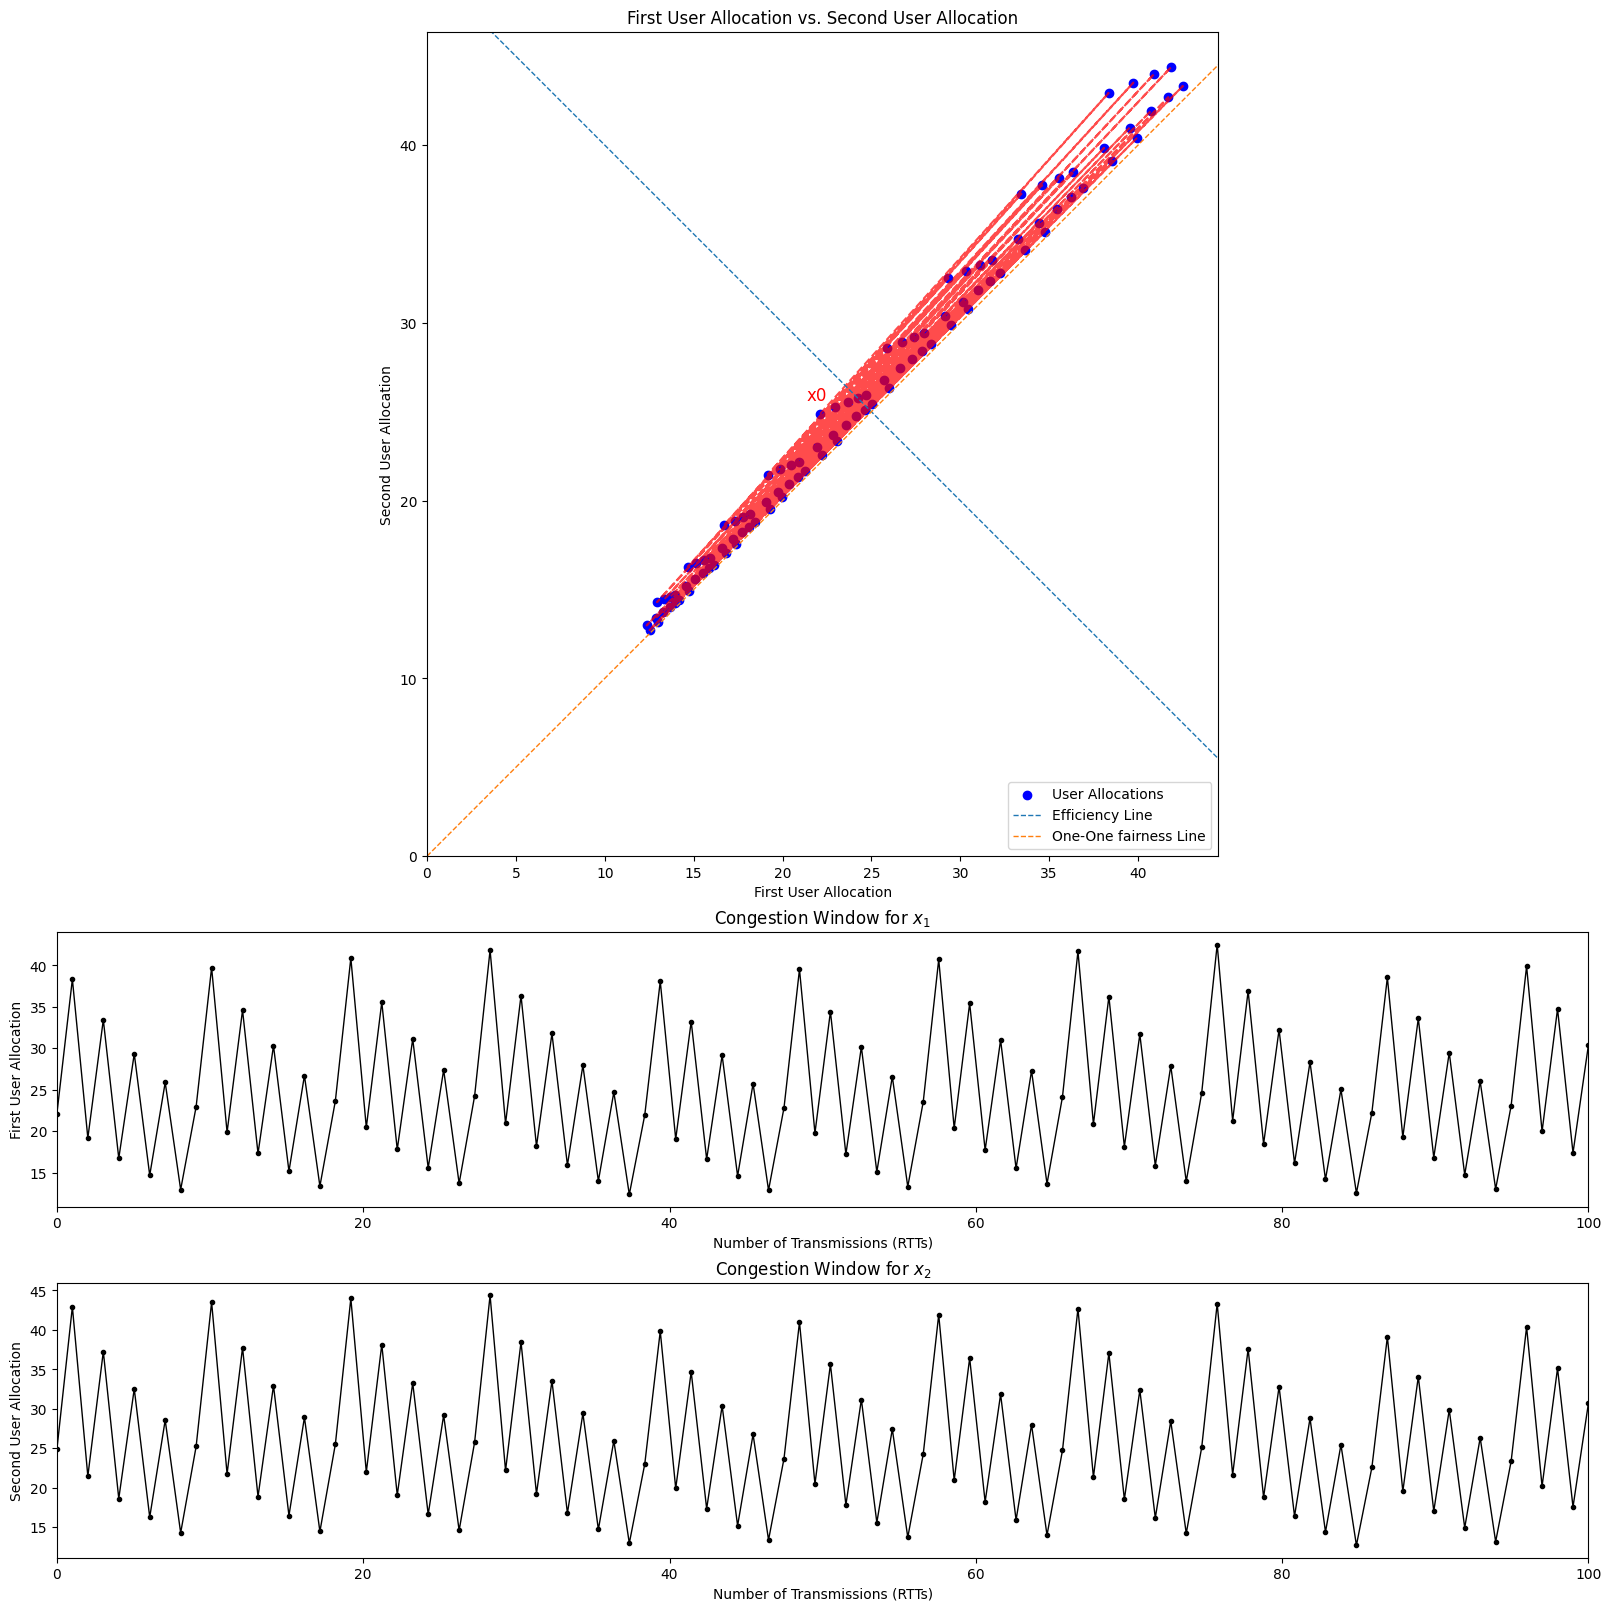

In [130]:
tcp_network.monitor_network()

[26.53922547 19.46077453]


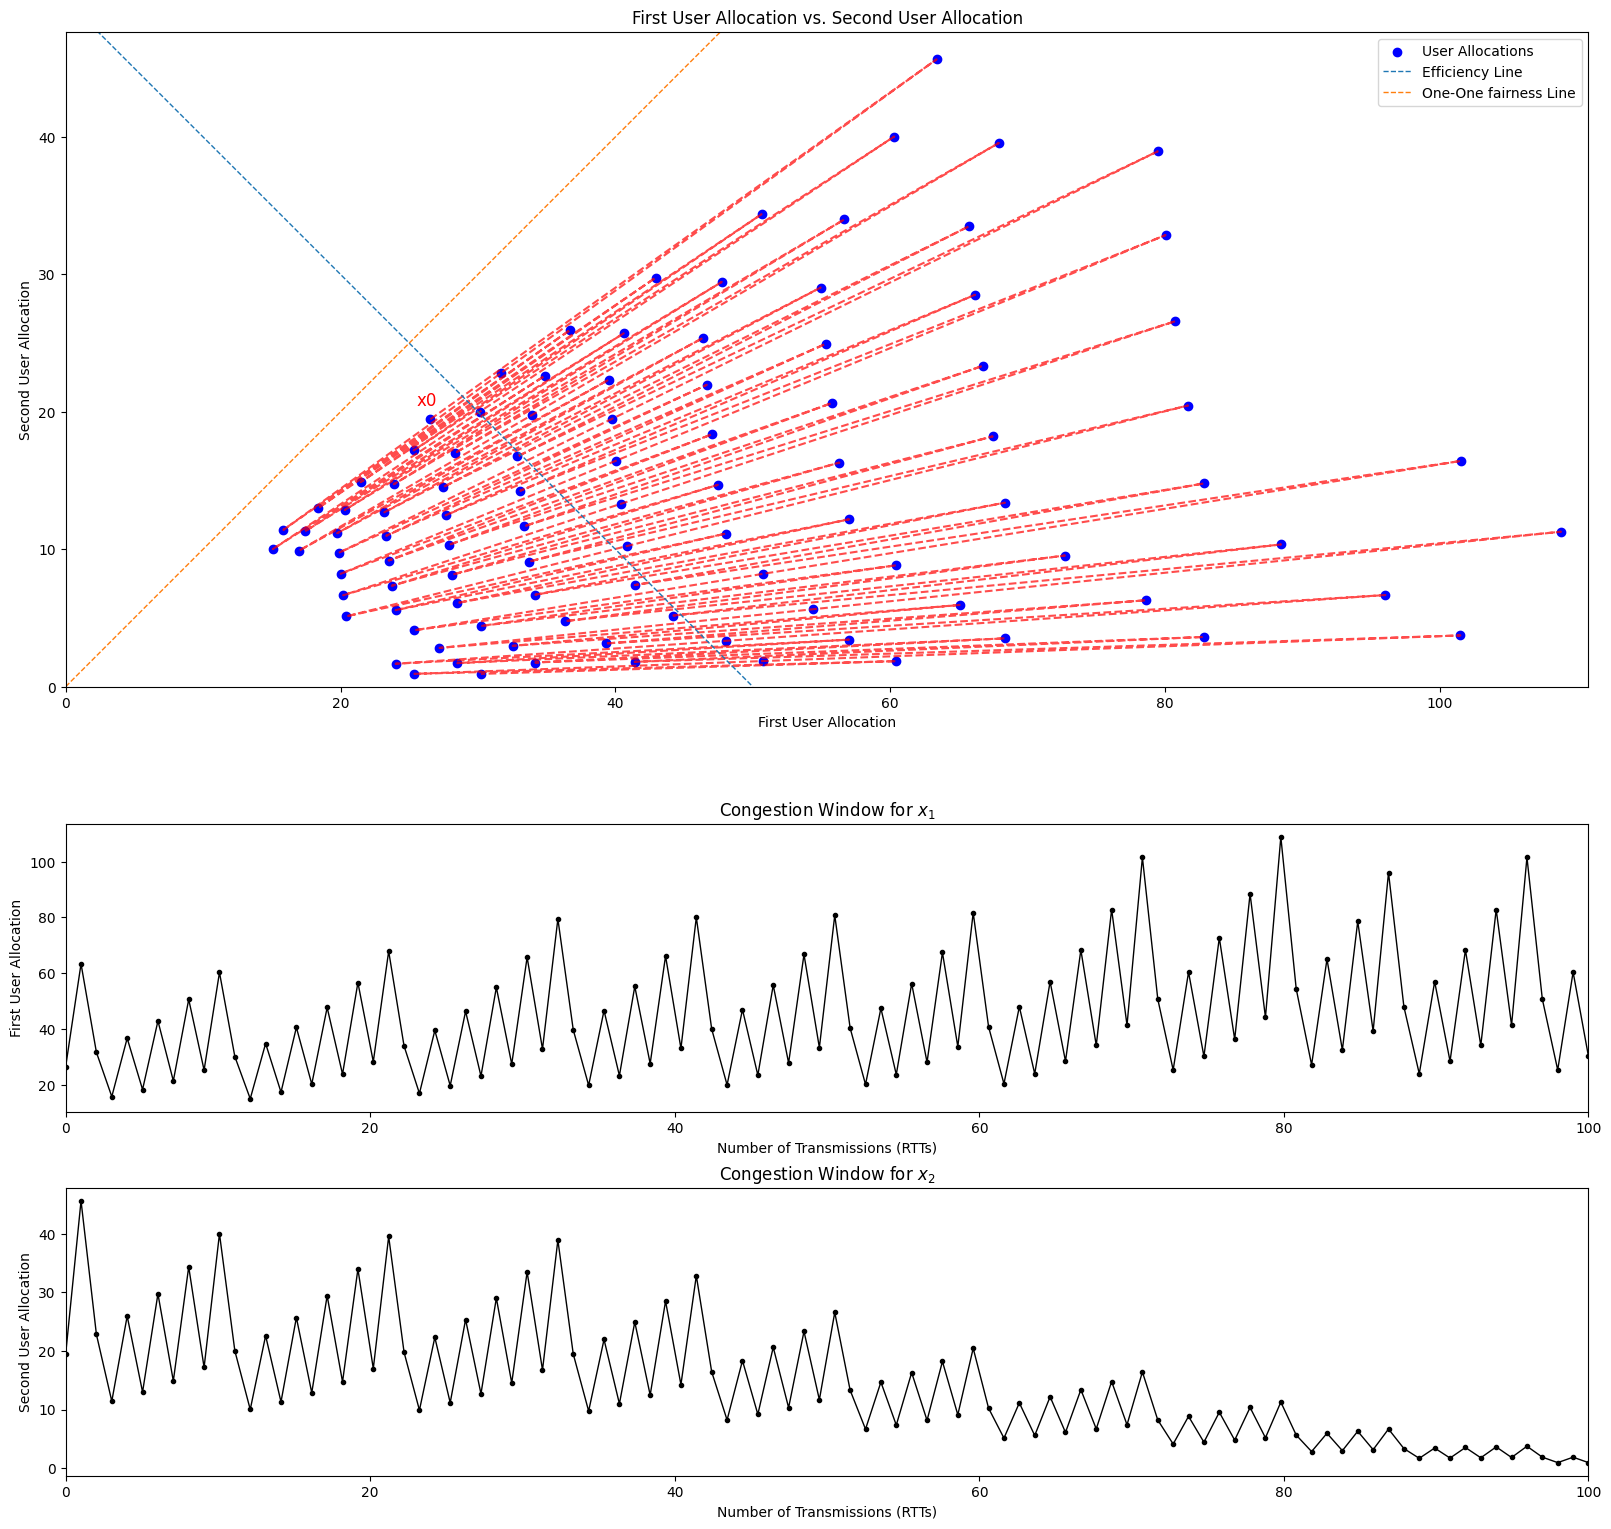

In [131]:
Algorithm = partial(PIMDAlgorithm, alpha_factor=1.1, beta_factor=0.5)
tcp_network = TCPNetwork(2, 50, Algorithm, 100)
tcp_network.monitor_network()

Logarithm Increase and Multiplicative Decrease (LIMD) for TCP

In [132]:
import math
class LIMDlgorithm(CongestionAlgorithm):
  def __init__(self, number_of_participants, band_width, alpha_factor, beta_factor):
    self.alpha_factor = [alpha_factor] * number_of_participants if isinstance(alpha_factor, numbers.Number)  else alpha_factor
    self.beta_factor = [beta_factor] * number_of_participants if isinstance(beta_factor, numbers.Number) else beta_factor
    super().__init__(number_of_participants, band_width)
  def _redistribute_allocation(self, current_allocation):
    if self.get_total_allocation(current_allocation) <= self.band_width:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] + math.log(current_allocation[i], self.alpha_factor[i])
    else:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] * self.beta_factor[i]
    return current_allocation

In [133]:
Algorithm = partial(LIMDlgorithm, alpha_factor=1.1, beta_factor=0.5)
tcp_network = TCPNetwork(2, 20, Algorithm, 100)

[8.61719227 8.38280773]


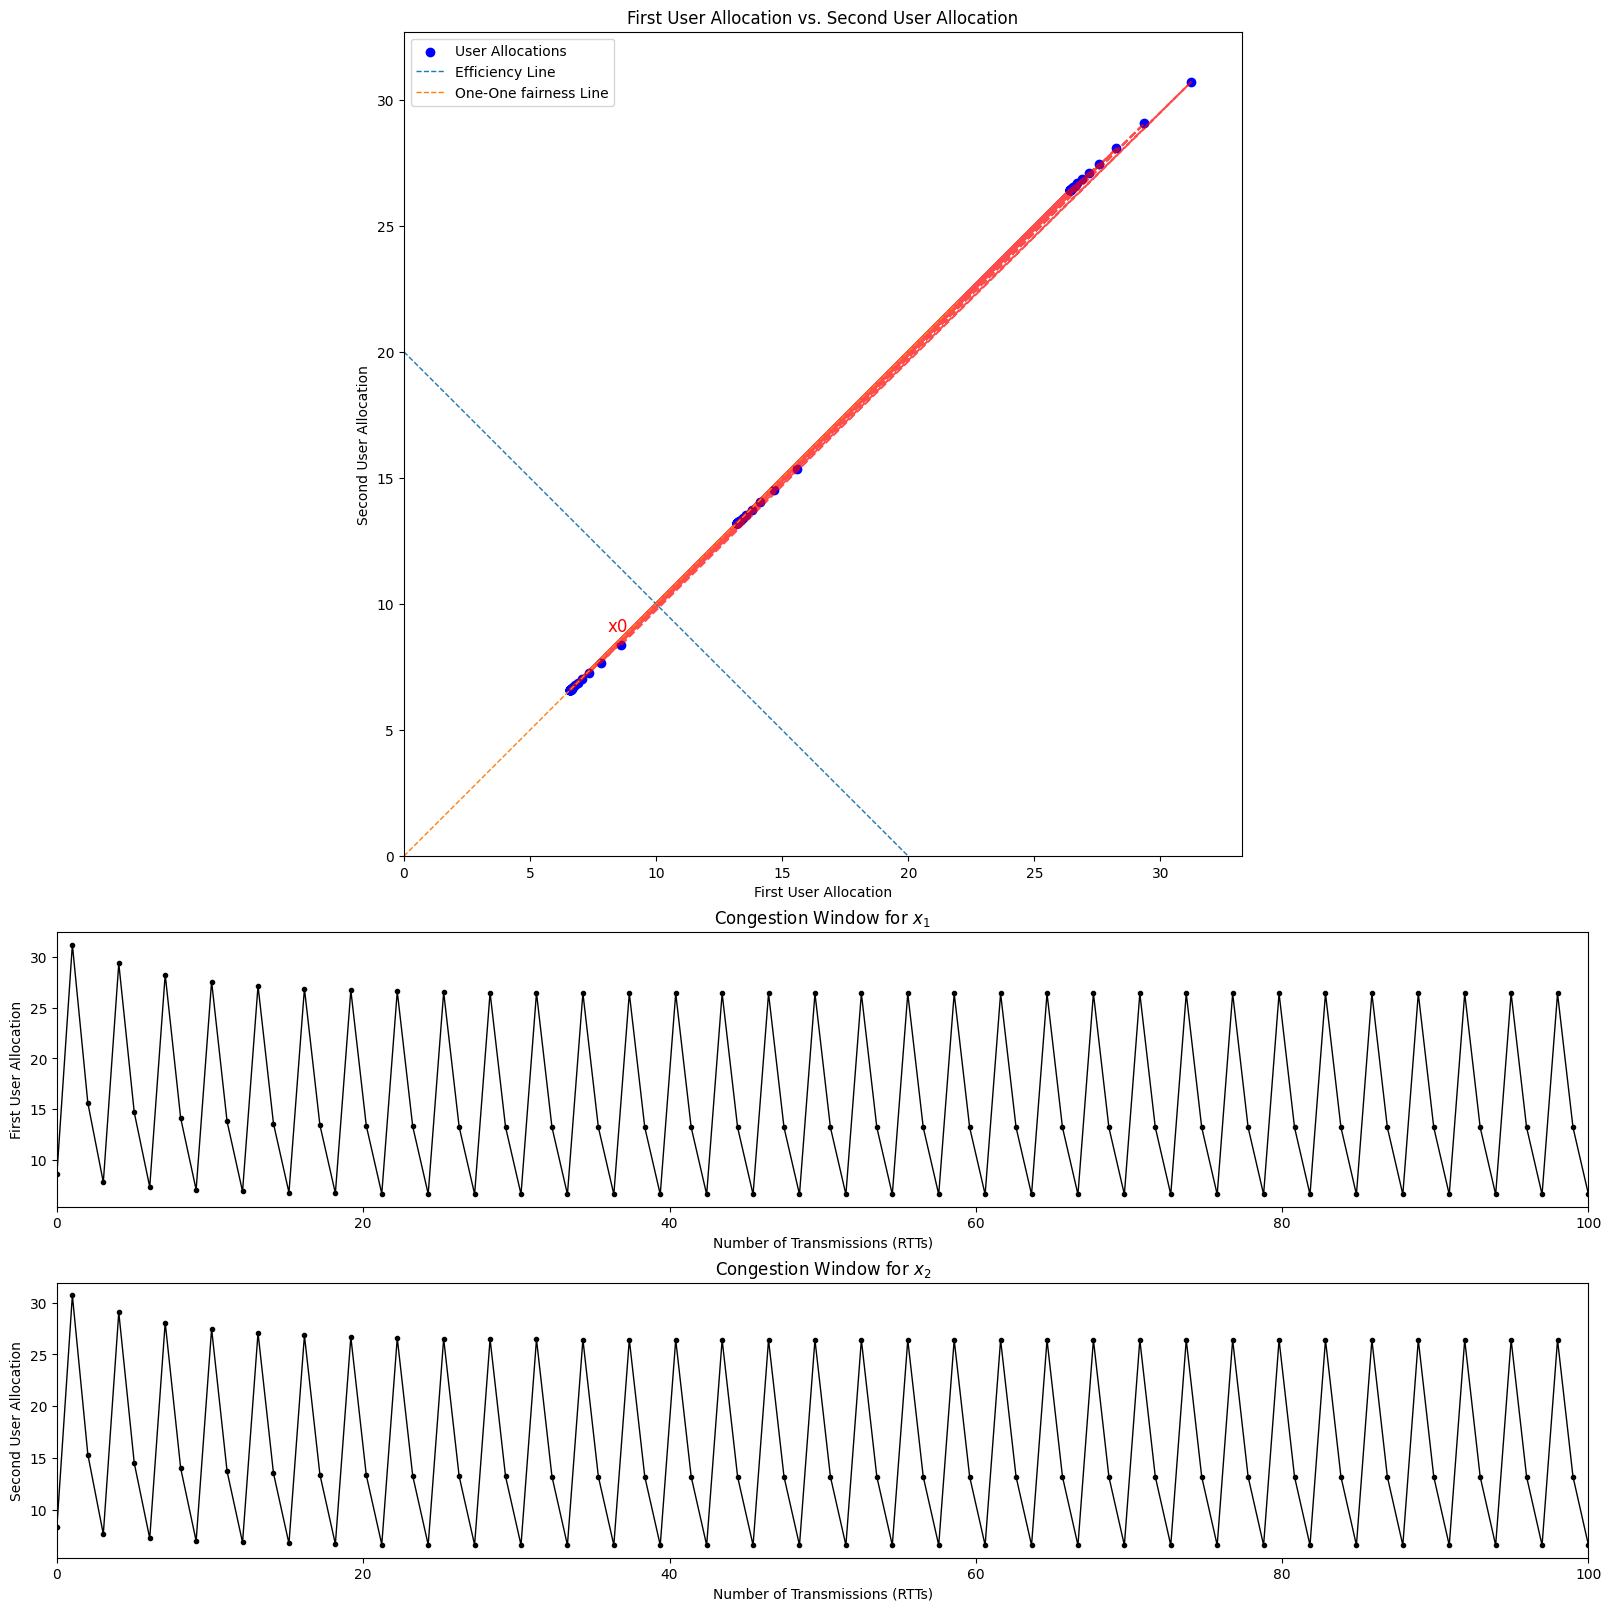

In [134]:
tcp_network.monitor_network()

## AI-tuned AIMD

In [198]:
import math
import json
class AItunedAIMDlgorithm(CongestionAlgorithm):
  def __init__(self, number_of_participants, band_width):
    self.LLM = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    super().__init__(number_of_participants, band_width)
  def _redistribute_allocation(self, current_allocation):
    self.query_factor_from_LLM()
    if self.get_total_allocation(current_allocation) <= self.band_width:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] + self.alpha_factor[i]
    else:
      for i in range(self.number_of_participants):
        current_allocation[i] = current_allocation[i] * self.beta_factor[i]
    return current_allocation
  def query_factor_from_LLM(self):
    response = self.LLM.models.generate_content(
        model='gemini-2.0-flash',
        contents=f"""You are an AI assistant designed to optimize TCP congestion control that using the AIMD (Additive Increase Multiplicative Decrease) algorithm.
        Your goal is dynamically tuning alpha and beta parameters to avoid congestion. You must only depend on each user allocation to determine thier factor. For example,
        for user 1, you are only allowed to use last_k_allocation_for_user_1 and is_congested to see if there is a congestion or not to determine their alpha and beta factor.

        You must return as dictionary only as expected response listed under. Please do not return me any your logic, just result

        The capacity of network is 50, number of participant is 5

        **Current State:**
        {{
            last_k_allocation_for_user_1: {[sublist[0] for sublist in self.k_lastest_allocation]},
            last_k_allocation_for_user_2: {[sublist[1] for sublist in self.k_lastest_allocation]},
            last_k_allocation_for_user_3: {[sublist[2] for sublist in self.k_lastest_allocation]},
            last_k_allocation_for_user_4: {[sublist[3] for sublist in self.k_lastest_allocation]},
            last_k_allocation_for_user_5: {[sublist[4] for sublist in self.k_lastest_allocation]},
            is_congested: {self.get_total_allocation(self.current_allocation) > 50}
        }}

        Expected Response Format:
        {{
            "alpha": [1, 2, 2, 1, 2],
            "beta": [0.2, 0.3, 0.9, 0.5, 0.6]
        }}"""
    )
    parsed_data = json.loads(response.text.strip("```json").strip("```").strip())
    self.alpha_factor = parsed_data["alpha"]
    self.beta_factor = parsed_data["beta"]

In [202]:
tcp_network = TCPNetwork(5, 50, AItunedAIMDlgorithm, 15)

[6.71421082 8.18025297 5.74215204 5.49985083 0.86353335]


[6.71421082 8.18025297 5.74215204 5.49985083 0.86353335]
[7.71421082 9.18025297 6.74215204 6.49985083 1.86353335]
[ 8.71421082 10.18025297  7.74215204  7.49985083  2.86353335]
[ 9.71421082 12.18025297  9.74215204  8.49985083  4.86353335]
[10.71421082 13.18025297 10.74215204  9.49985083  5.86353335]
[11.71421082 14.18025297 11.74215204 10.49985083  6.86353335]
[ 2.34284216  4.25407589 10.56793683  5.24992541  4.11812001]
[ 3.34284216  5.25407589 11.56793683  6.24992541  5.11812001]
[ 4.34284216  6.25407589 12.56793683  7.24992541  6.11812001]
[ 5.34284216  7.25407589 13.56793683  8.24992541  7.11812001]
[ 6.34284216  8.25407589 14.56793683  9.24992541  8.11812001]
[ 7.34284216  9.25407589 15.56793683 10.24992541  9.11812001]
[ 1.46856843  2.77622277 14.01114315  5.12496271  5.47087201]
[ 2.46856843  3.77622277 15.01114315  6.12496271  6.47087201]
[ 3.46856843  4.77622277 16.01114315  7.12496271  7.47087201]


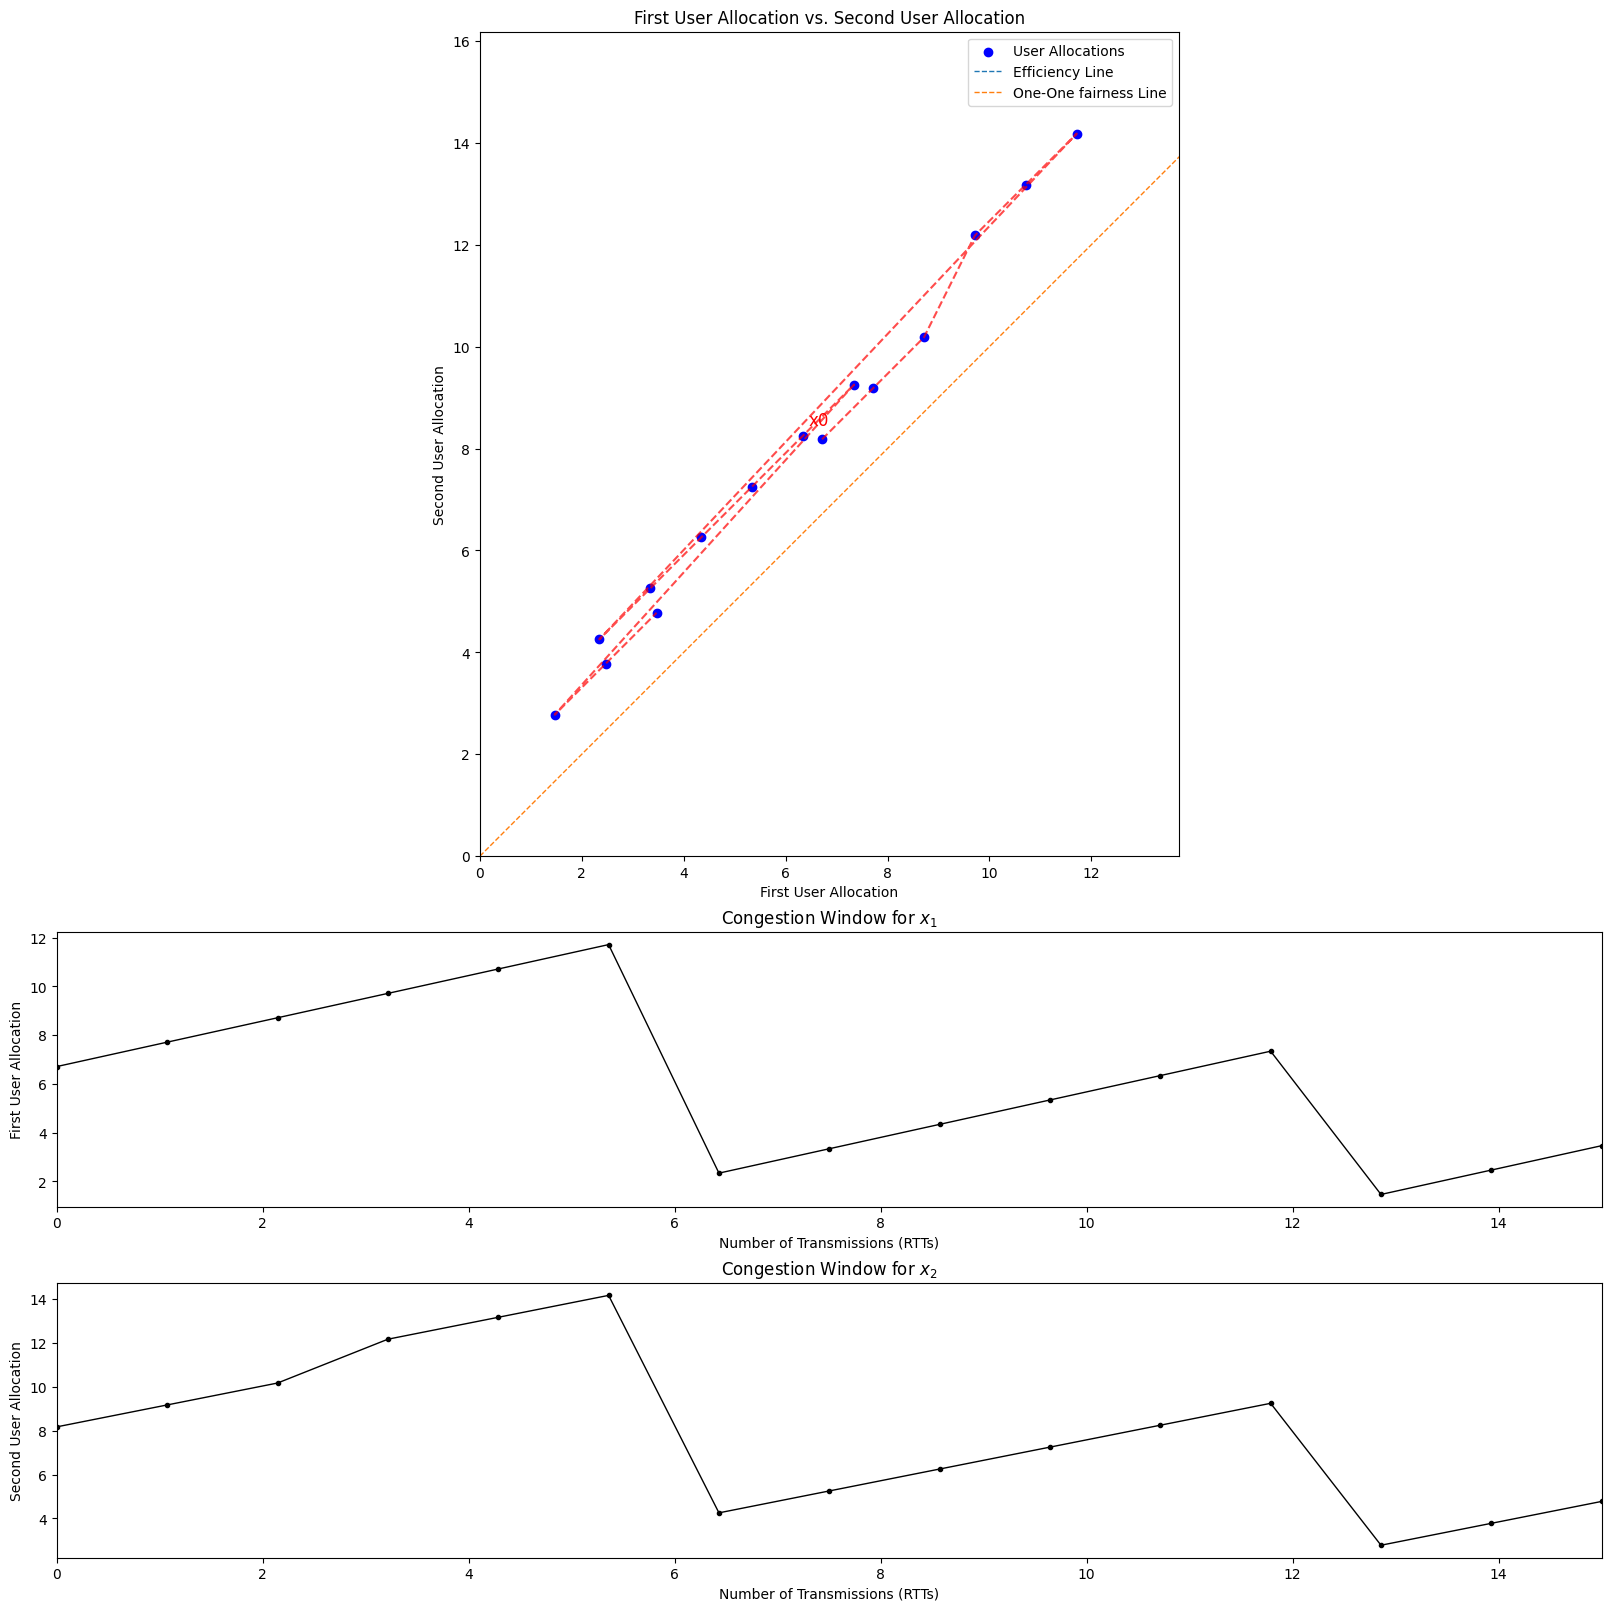

In [203]:
tcp_network.monitor_network(verbose=True)